In [1]:
import sys
import os
import glob
from pathlib import Path
import random
import time
import datetime
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score
import re
import transformers
import torch 
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
%matplotlib inline
sns.set_theme(style='darkgrid')

In [2]:
from pkg.UTHBERT.preprocess_text import preprocess as my_preprocess
from pkg.UTHBERT.tokenization_mod import MecabTokenizer, FullTokenizerForMecab
from transformers import BertModel,BertConfig

In [3]:
def get_device() -> str:
    """
    Returns the best available device for PyTorch computations.
    """
    if torch.backends.mps.is_available():
        # macOS with Apple Silicon (MPS backend)
        return "mps"
    elif torch.cuda.is_available():
        # NVIDIA GPU
        return "cuda"
    else:
        # Fallback to CPU
        return "cpu"

try:
    device = torch.device(get_device())
    print(f"Using device: {device}")
except RuntimeError as e:
    print(f"Failed to initialize the device: {e}")
    device = torch.device("cpu")  # Fallback to CPU in case of an error

Using device: mps


In [4]:
seed=0
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False #Trueで高速化重視, Falseで再現性重視
seed_everything(seed)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
torch.use_deterministic_algorithms(True)
torch.set_num_threads(1)

# Tokenizer

In [5]:
dic_path = './dic'

In [6]:
# special token for a Person's name (Do not change)
name_token = "＠＠Ｎ"

# path to the mecab-ipadic-neologd
mecab_ipadic_neologd = dic_path + '/mecab-ipadic-neologd'

# path to the J-Medic (We used MANBYO_201907_Dic-utf8.dic)
mecab_J_medic = dic_path + '/MANBYO/MANBYO_201907_Dic-utf8.dic'

# path to the uth-bert vocabulary
vocab_file = dic_path + '/UTH-BERT/bert_vocab_mc_v1_25000.txt'

In [7]:
# MecabTokenizer
sub_tokenizer = MecabTokenizer(mecab_ipadic_neologd=mecab_ipadic_neologd,
                               mecab_J_medic=mecab_J_medic,
                               name_token=name_token)

# FullTokenizerForMecab
tokenizer = FullTokenizerForMecab(sub_tokenizer=sub_tokenizer,
                                  vocab_file=vocab_file,
                                  do_lower_case=False)

In [8]:
def tokenize(sentence_list):
    token_list = []
    for s in tqdm(sentence_list):
        tokens = tokenizer.tokenize(my_preprocess(str(s)))
        ids = tokenizer.convert_tokens_to_ids(tokens)
        ids = [2] + ids + [3]
        token_list.append(ids)
    return token_list

# Data

In [9]:
def create_dataframe(folder_path):
    """
    指定されたフォルダ内のテキストファイルからDataFrameを作成する関数

    Args:
        folder_path (str): テキストファイルが入っているフォルダのパス

    Returns:
        pandas.DataFrame: 作成されたDataFrame
    """

    # sentence.csvを読み込む
    df_text = pd.read_csv(os.path.join(folder_path, "sentences.csv"))
    # label.csvを読み込む
    df_label = pd.read_csv(os.path.join(folder_path, "label.csv"))

    df_text['index'] = df_text['id'].astype(str) + '_' + df_text['sentence_index'].astype(str)
    df_label['index'] = df_label['id'].astype(str) + '_' + df_label['sentence_index'].astype(str)
    
    # textとlabelのDataFrameを結合
    df = pd.merge(df_text, df_label, on='index', how='inner')
    df['id'] = df['id_x'].combine_first(df['id_y'])
    df = df.drop(columns=['id_x', 'id_y'])
    df['sentence_index'] = df['sentence_index_x'].combine_first(df['sentence_index_y'])
    df = df.drop(columns=['sentence_index_x', 'sentence_index_y'])
    cols = ['index','id','sentence_index'] + [col for col in df.columns if col not in ['index','id','sentence_index']]
    df = df[cols]

    return df

train_folder_path = "../../radnlp_2024_train_val_20240731/ja/sub_task/train"
train_df = create_dataframe(train_folder_path)
val_folder_path = "../../radnlp_2024_train_val_20240731/ja/sub_task/val"
val_df = create_dataframe(val_folder_path)

In [10]:
train_df.head(10)

,index,id,sentence_index,text,omittable,measure,extension,atelectasis,satellite,lymphadenopathy,pleural,distant
0,56344_0,56344,0,左上葉全体が無気肺になっています。,0,0,0,1,0,0,0,0
1,56344_1,56344,1,左上葉気管支は閉塞して造影 CT で増強効果の乏しい 74mm の腫瘤があります。,0,1,1,0,0,0,0,0
2,56344_2,56344,2,肺癌と考えます。,0,1,0,0,0,0,0,0
3,56344_3,56344,3,左肺門、同側縦隔リンパ節腫大しリンパ節転移と考えます。,0,0,0,0,0,1,0,0
4,56344_4,56344,4,気管右側にもリンパ節腫大があり、こちらもリンパ節転移を疑います。,0,0,0,0,0,1,0,0
5,56344_5,56344,5,左下葉気管支も腫瘍により浸潤あり、狭窄しています。,0,0,1,0,0,0,0,0
6,56344_6,56344,6,胸水貯留は認めません。,1,0,0,0,0,0,0,0
7,56344_7,56344,7,撮影範囲の腹部臓器に粗大な異常を認めません。,1,0,0,0,0,0,0,0
8,133166_0,133166,0,右下葉 S8 に⻑径 30mm の腫瘤性病変があります。,0,1,0,0,0,0,0,0
9,133166_1,133166,1,辺縁には spicula を伴っています。,1,0,0,0,0,0,0,0


In [11]:
print(train_df['omittable'].value_counts())
print(train_df['measure'].value_counts())
print(train_df['extension'].value_counts())
print(train_df['atelectasis'].value_counts())
print(train_df['satellite'].value_counts())
print(train_df['lymphadenopathy'].value_counts())
print(train_df['pleural'].value_counts())
print(train_df['distant'].value_counts())

omittable
0    562
1    458
Name: count, dtype: int64
measure
0    833
1    187
Name: count, dtype: int64
extension
0    908
1    112
Name: count, dtype: int64
atelectasis
0    987
1     33
Name: count, dtype: int64
satellite
0    946
1     74
Name: count, dtype: int64
lymphadenopathy
0    907
1    113
Name: count, dtype: int64
pleural
0    994
1     26
Name: count, dtype: int64
distant
0    935
1     85
Name: count, dtype: int64


In [12]:
len(train_df)

1020

In [13]:
X_train, X_valid = tokenize(train_df['text'].values.tolist()), tokenize(val_df['text'].values.tolist())
Yomit_train, Yomit_valid = train_df['omittable'].values.tolist(), val_df['omittable'].values.tolist()
Ymeas_train, Ymeas_valid = train_df['measure'].values.tolist(), val_df['measure'].values.tolist()
Yexte_train, Yexte_valid = train_df['extension'].values.tolist(), val_df['extension'].values.tolist()
Yatel_train, Yatel_valid = train_df['atelectasis'].values.tolist(), val_df['atelectasis'].values.tolist()
Ysate_train, Ysate_valid = train_df['satellite'].values.tolist(), val_df['satellite'].values.tolist()
Ylymp_train, Ylymp_valid = train_df['lymphadenopathy'].values.tolist(), val_df['lymphadenopathy'].values.tolist()
Ypleu_train, Ypleu_valid = train_df['pleural'].values.tolist(), val_df['pleural'].values.tolist()
Ydist_train, Ydist_valid = train_df['distant'].values.tolist(), val_df['distant'].values.tolist()

  0%|          | 0/1020 [00:00<?, ?it/s]

  0%|          | 0/451 [00:00<?, ?it/s]

# subtask各々で分類モデルを学習

In [14]:
model_path = Path('./pkg/UTHBERT')
save_path = Path('./model')

In [15]:
num_classes=2

In [16]:
class MyCollator(object):
    '''
    Args:
    test : Set True when using with test data loader. Defaults to False
    percentile : Trim sequences by this percentile
    '''
    def __init__(self,test=False,percentile=100):
        self.test = test
        self.percentile = percentile
    def __call__(self, batch):
        if not self.test:
            data = [torch.tensor(item[0])  for item in batch]
            target = [item[1] for item in batch]
        else:
            data = [item for item in batch]
        
        # Padding
        data = pad_sequence(data, batch_first=True)
        data = data.clone().detach().long()
        masks = torch.where(data==0, 1, 0)
        masks = masks.clone().detach().long()
        if not self.test:
            target = torch.tensor(target, dtype=torch.long)
            return [data, masks, target]
        return [data, masks]

In [17]:
def build_data(train_data, valid_data, batch_size=8): 
        
    collate = MyCollator(percentile=100)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate) 
    valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate) 
     
    return train_loader, valid_loader

In [18]:
config = BertConfig.from_json_file(model_path / 'bert_config.json')
bert = BertModel.from_pretrained(model_path / 'UTH_BERT.bin', config=config)

class Net(nn.Module):
    def __init__(self, bert, num_classes):
        super(Net, self).__init__()
        self.bert = bert
        self.cls = nn.Linear(768, num_classes)

  # @torch.cuda.amp.autocast()
    def forward(self, inputs_ids, pad_masks, Attention=False):
        bout = self.bert(inputs_ids, pad_masks, output_attentions=Attention)
        bs = len(bout[0])
        h0 = [bout[0][i][0] for i in range(bs)]
        h0 = torch.stack(h0,dim=0)
        if Attention:
            return self.cls(h0),bout
        else:
            return self.cls(h0)

In [19]:
def plot_loss(train_loss, valid_loss):
    plt.plot(train_loss)
    plt.plot(valid_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train_loss', 'valid_loss'], loc='upper right')
    plt.xticks(np.arange(0, len(train_loss) + 1, 5))
    plt.show()

In [20]:
def plot_metrics(train_acc, test_acc):
    plt.plot(train_acc)
    plt.plot(test_acc)
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['train_acc', 'valid_acc'], loc='lower right')
    plt.xticks(np.arange(0, len(train_acc) + 1, 5))
    plt.show()

In [21]:
def synchronize():
    if torch.backends.mps.is_available():
        torch.mps.synchronize()
    elif torch.cuda.is_available():
        torch.cuda.synchronize()

def run(train_loader, valid_loader, model, num_classes, epochs=10, patience=5, delta=0.0, save_path=save_path):
    
    train_loss, valid_loss, train_acc, valid_acc = [], [], [], []
    best_acc, best_acc_epoch = 0.0, 0
    best_valid_loss = np.inf
    patience_counter = 0
    
    for epoch in range(0, epochs): 
        print(f'\nEpoch {epoch + 1}/{epochs}')
        print('-' * 10)
        epoch_train_loss, epoch_valid_loss = 0.0, 0.0
        epoch_train_acc = 0.0

        model.train() 
        start = time.time()
        for data in tqdm(train_loader): 
            inputs, masks, labels = data[0].to(device), data[1].to(device), data[2].to(device)
            optimizer.zero_grad() 
            outputs = model(inputs, masks)
            loss = criterion(outputs, labels)  
            loss.backward() 
            optimizer.step() 
            epoch_train_loss += loss.item() / len(train_loader) 
            acc = (F.softmax(outputs, dim=1).argmax(dim=1) == labels).float().mean()
            epoch_train_acc += acc.item() / len(train_loader)
            del inputs, masks, labels, outputs, loss    

        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
        synchronize()
        elapsed_time = time.time() - start
        print(f'Train loss: {epoch_train_loss:.4f}, Train acc: {epoch_train_acc:.4f}, Time: {elapsed_time:.0f}s')
        
        model.eval()
        label_li, pred_li = [], []
        with torch.no_grad():
            for data in valid_loader:
                inputs, masks, labels = data[0].to(device), data[1].to(device), data[2].to(device)
                outputs = model(inputs, masks)
                loss = criterion(outputs, labels)
                epoch_valid_loss += loss.item() / len(valid_loader)
                preds = F.softmax(outputs, dim=1).argmax(dim=1)
                label_li.extend(labels.cpu().numpy())
                pred_li.extend(preds.cpu().numpy())

        valid_loss.append(epoch_valid_loss)
        epoch_valid_acc = accuracy_score(label_li, pred_li)
        valid_acc.append(epoch_valid_acc)

        print(f'Valid loss: {epoch_valid_loss:.4f}, Valid acc: {epoch_valid_acc:.4f}')

        if epoch_valid_acc > best_acc: 
            best_acc = epoch_valid_acc
            best_acc_epoch = epoch
            torch.save(model.state_dict(), save_path / f'best_acc_2.pth')

        # # Early stopping
        # if epoch_valid_loss < best_valid_loss - delta:
        #     best_valid_loss = epoch_valid_loss
        #     patience_counter = 0  # 改善があったので、カウンタをリセット
        # else:
        #     patience_counter += 1
        # if patience_counter >= patience:
        #     print(f'Early stopping at epoch {epoch + 1}')
        #     break
            
    print('\nTraining complete')
    print(f'Best ACC: {best_acc:.4f} at epoch {best_acc_epoch}')

    return train_loss, valid_loss, train_acc, valid_acc 

In [22]:
batch_size=2
epochs=20
learning_rate=1e-5
momentum=0.9

## Omittableモデル

In [23]:
train_data = []
valid_data = []
for x, y in zip(X_train, Yomit_train):
    data = [x, y]
    train_data.append(data)
for x, y in zip(X_valid, Yomit_valid):
    data = [x, y]
    valid_data.append(data)
    
train_loader, valid_loader = build_data(train_data, valid_data, batch_size=batch_size)

In [24]:
config = BertConfig.from_json_file(model_path / 'bert_config.json')
bert = BertModel.from_pretrained(model_path / 'UTH_BERT.bin', config=config)
model = Net(bert, num_classes).to(device)

FREEZE=False
if FREEZE: 
    idx=1 #Any
    for name, param in model.named_parameters(): 
        param.requires_grad = False 
    for name, param in list(model.named_parameters())[idx:]: 
        param.requires_grad = True 
#     optimizer = optim.SGD([{'params':list(model.parameters())[idx:], 'lr':learning_rate, 'momentum':momentum}])
    optimizer = optim.Adam([{'params':list(model.parameters())[idx:], 'lr':learning_rate}]) 
    criterion = nn.CrossEntropyLoss()
else:  
#     optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [25]:
train_loss, valid_loss, train_acc, valid_acc = run(train_loader, valid_loader, model,
                                                             num_classes, epochs=epochs,
                                                             save_path=save_path/'omit')


Epoch 1/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.4950, Train acc: 0.7029, Time: 83s
Valid loss: 0.6468, Valid acc: 0.6075

Epoch 2/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.4488, Train acc: 0.7196, Time: 90s
Valid loss: 0.5120, Valid acc: 0.6541

Epoch 3/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.4079, Train acc: 0.7559, Time: 102s
Valid loss: 0.4110, Valid acc: 0.7339

Epoch 4/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.3997, Train acc: 0.7578, Time: 96s
Valid loss: 0.4701, Valid acc: 0.7517

Epoch 5/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.3845, Train acc: 0.7647, Time: 95s
Valid loss: 0.4728, Valid acc: 0.7206

Epoch 6/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.3858, Train acc: 0.7529, Time: 98s
Valid loss: 0.4895, Valid acc: 0.7140

Epoch 7/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.3740, Train acc: 0.7637, Time: 95s
Valid loss: 0.4674, Valid acc: 0.7029

Epoch 8/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.3799, Train acc: 0.7608, Time: 94s
Valid loss: 0.5098, Valid acc: 0.6918

Epoch 9/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.3791, Train acc: 0.7618, Time: 99s
Valid loss: 0.6069, Valid acc: 0.6430

Epoch 10/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.3638, Train acc: 0.7853, Time: 94s
Valid loss: 0.6928, Valid acc: 0.6585

Epoch 11/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.3602, Train acc: 0.7608, Time: 96s
Valid loss: 0.5813, Valid acc: 0.7384

Epoch 12/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.3972, Train acc: 0.7441, Time: 100s
Valid loss: 0.4280, Valid acc: 0.7317

Epoch 13/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.3760, Train acc: 0.7725, Time: 94s
Valid loss: 0.4598, Valid acc: 0.7206

Epoch 14/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.4450, Train acc: 0.7451, Time: 93s
Valid loss: 0.5343, Valid acc: 0.6718

Epoch 15/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.4186, Train acc: 0.7559, Time: 95s
Valid loss: 0.5408, Valid acc: 0.7095

Epoch 16/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.3938, Train acc: 0.7725, Time: 93s
Valid loss: 0.4350, Valid acc: 0.7384

Epoch 17/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.3527, Train acc: 0.7755, Time: 93s
Valid loss: 0.6651, Valid acc: 0.6386

Epoch 18/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.4097, Train acc: 0.7569, Time: 96s
Valid loss: 0.5016, Valid acc: 0.6896

Epoch 19/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.3905, Train acc: 0.7627, Time: 92s
Valid loss: 0.4785, Valid acc: 0.6918

Epoch 20/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.3724, Train acc: 0.7686, Time: 90s
Valid loss: 0.4892, Valid acc: 0.6962

Training complete
Best ACC: 0.7517 at epoch 3


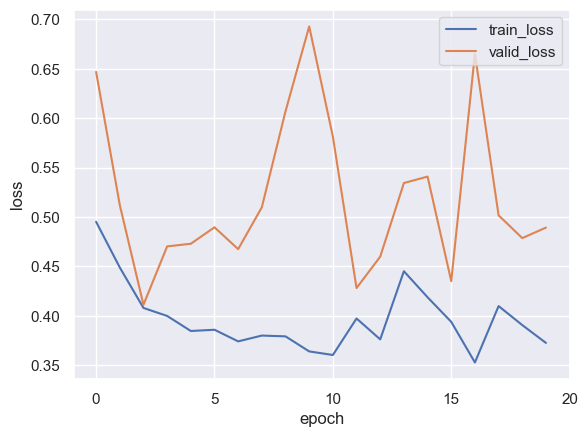

In [26]:
plot_loss(train_loss, valid_loss)

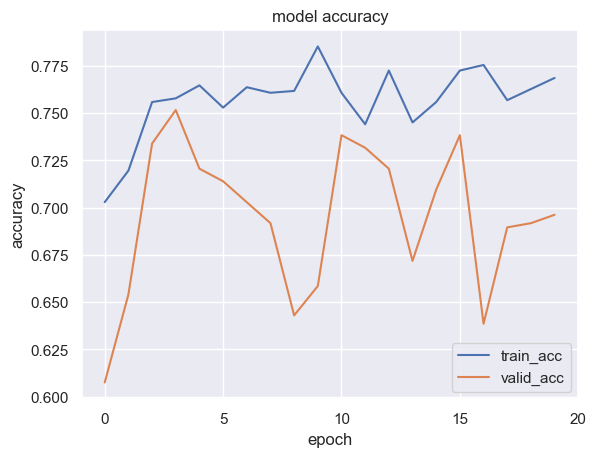

In [27]:
plot_metrics(train_acc, valid_acc)

In [28]:
print(f'accuracy: {max(valid_acc)}')

accuracy: 0.7516629711751663


## Measureモデル

In [29]:
train_data = []
valid_data = []
for x, y in zip(X_train, Ymeas_train):
    data = [x, y]
    train_data.append(data)
for x, y in zip(X_valid, Ymeas_valid):
    data = [x, y]
    valid_data.append(data)
    
train_loader, valid_loader = build_data(train_data, valid_data, batch_size=batch_size)

In [30]:
config = BertConfig.from_json_file(model_path / 'bert_config.json')
bert = BertModel.from_pretrained(model_path / 'UTH_BERT.bin', config=config)
model = Net(bert, num_classes).to(device)

FREEZE=False
if FREEZE: 
    idx=1 #Any
    for name, param in model.named_parameters(): 
        param.requires_grad = False 
    for name, param in list(model.named_parameters())[idx:]: 
        param.requires_grad = True 
#     optimizer = optim.SGD([{'params':list(model.parameters())[idx:], 'lr':learning_rate, 'momentum':momentum}])
    optimizer = optim.Adam([{'params':list(model.parameters())[idx:], 'lr':learning_rate}]) 
    criterion = nn.CrossEntropyLoss()
else:  
#     optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [31]:
train_loss, valid_loss, train_acc, valid_acc = run(train_loader, valid_loader, model,
                                                             num_classes, epochs=epochs,
                                                             save_path=save_path/'meas')


Epoch 1/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.3688, Train acc: 0.8853, Time: 93s
Valid loss: 0.3446, Valid acc: 0.8692

Epoch 2/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.3086, Train acc: 0.8853, Time: 93s
Valid loss: 0.3984, Valid acc: 0.8803

Epoch 3/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2856, Train acc: 0.9020, Time: 93s
Valid loss: 0.3397, Valid acc: 0.8936

Epoch 4/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2715, Train acc: 0.9069, Time: 98s
Valid loss: 0.3120, Valid acc: 0.8936

Epoch 5/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2595, Train acc: 0.9108, Time: 98s
Valid loss: 0.3261, Valid acc: 0.8758

Epoch 6/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2627, Train acc: 0.9127, Time: 95s
Valid loss: 0.3785, Valid acc: 0.8470

Epoch 7/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2677, Train acc: 0.9098, Time: 95s
Valid loss: 0.3232, Valid acc: 0.8825

Epoch 8/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2414, Train acc: 0.9176, Time: 93s
Valid loss: 0.3061, Valid acc: 0.9002

Epoch 9/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2284, Train acc: 0.9216, Time: 91s
Valid loss: 0.3555, Valid acc: 0.8936

Epoch 10/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2453, Train acc: 0.9186, Time: 94s
Valid loss: 0.3493, Valid acc: 0.8803

Epoch 11/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2653, Train acc: 0.9098, Time: 94s
Valid loss: 0.3593, Valid acc: 0.8758

Epoch 12/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.3351, Train acc: 0.8882, Time: 91s
Valid loss: 0.3239, Valid acc: 0.8758

Epoch 13/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.3482, Train acc: 0.8755, Time: 94s
Valid loss: 0.3074, Valid acc: 0.8936

Epoch 14/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2891, Train acc: 0.8990, Time: 94s
Valid loss: 0.4033, Valid acc: 0.8625

Epoch 15/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2883, Train acc: 0.9029, Time: 92s
Valid loss: 0.3870, Valid acc: 0.8492

Epoch 16/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.3077, Train acc: 0.8990, Time: 93s
Valid loss: 0.3074, Valid acc: 0.8891

Epoch 17/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2604, Train acc: 0.9098, Time: 94s
Valid loss: 0.3569, Valid acc: 0.8847

Epoch 18/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2663, Train acc: 0.9069, Time: 91s
Valid loss: 0.4716, Valid acc: 0.8603

Epoch 19/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2981, Train acc: 0.9000, Time: 93s
Valid loss: 0.5178, Valid acc: 0.7805

Epoch 20/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.3010, Train acc: 0.8794, Time: 94s
Valid loss: 0.3258, Valid acc: 0.8847

Training complete
Best ACC: 0.9002 at epoch 7


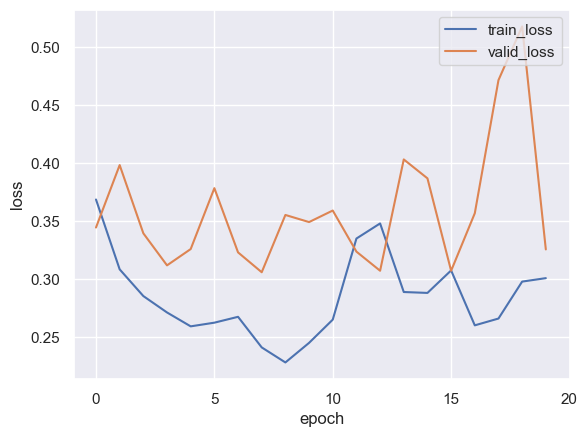

In [32]:
plot_loss(train_loss, valid_loss)

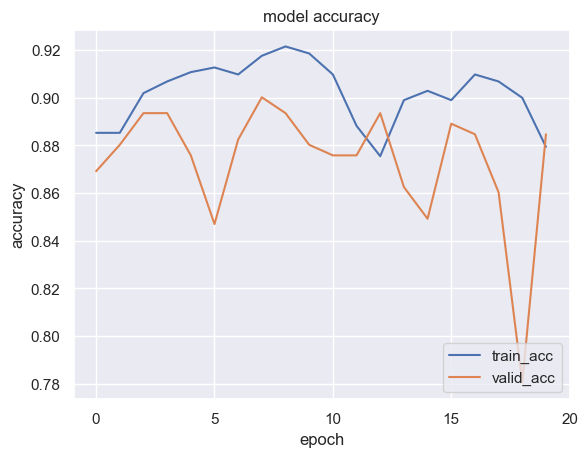

In [33]:
plot_metrics(train_acc, valid_acc)

In [34]:
print(f'accuracy: {max(valid_acc)}')

accuracy: 0.9002217294900222


## Extensionモデル

In [35]:
train_data = []
valid_data = []
for x, y in zip(X_train, Yexte_train):
    data = [x, y]
    train_data.append(data)
for x, y in zip(X_valid, Yexte_valid):
    data = [x, y]
    valid_data.append(data)
    
train_loader, valid_loader = build_data(train_data, valid_data, batch_size=batch_size)

In [36]:
config = BertConfig.from_json_file(model_path / 'bert_config.json')
bert = BertModel.from_pretrained(model_path / 'UTH_BERT.bin', config=config)
model = Net(bert, num_classes).to(device)

FREEZE=False
if FREEZE: 
    idx=1 #Any
    for name, param in model.named_parameters(): 
        param.requires_grad = False 
    for name, param in list(model.named_parameters())[idx:]: 
        param.requires_grad = True 
#     optimizer = optim.SGD([{'params':list(model.parameters())[idx:], 'lr':learning_rate, 'momentum':momentum}])
    optimizer = optim.Adam([{'params':list(model.parameters())[idx:], 'lr':learning_rate}]) 
    criterion = nn.CrossEntropyLoss()
else:  
#     optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [37]:
train_loss, valid_loss, train_acc, valid_acc = run(train_loader, valid_loader, model,
                                                             num_classes, epochs=epochs,
                                                             save_path=save_path/'exte')


Epoch 1/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2770, Train acc: 0.9127, Time: 91s
Valid loss: 0.1971, Valid acc: 0.9401

Epoch 2/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2039, Train acc: 0.9363, Time: 92s
Valid loss: 0.1684, Valid acc: 0.9468

Epoch 3/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1960, Train acc: 0.9441, Time: 94s
Valid loss: 0.2004, Valid acc: 0.9401

Epoch 4/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1731, Train acc: 0.9490, Time: 91s
Valid loss: 0.1527, Valid acc: 0.9557

Epoch 5/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1763, Train acc: 0.9520, Time: 91s
Valid loss: 0.2229, Valid acc: 0.9290

Epoch 6/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1625, Train acc: 0.9559, Time: 94s
Valid loss: 0.1777, Valid acc: 0.9424

Epoch 7/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1475, Train acc: 0.9588, Time: 92s
Valid loss: 0.2674, Valid acc: 0.9224

Epoch 8/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2123, Train acc: 0.9402, Time: 92s
Valid loss: 0.3037, Valid acc: 0.9202

Epoch 9/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1966, Train acc: 0.9431, Time: 93s
Valid loss: 0.1923, Valid acc: 0.9424

Epoch 10/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1635, Train acc: 0.9539, Time: 92s
Valid loss: 0.1940, Valid acc: 0.9401

Epoch 11/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1627, Train acc: 0.9569, Time: 91s
Valid loss: 0.1871, Valid acc: 0.9468

Epoch 12/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1610, Train acc: 0.9549, Time: 94s
Valid loss: 0.2119, Valid acc: 0.9468

Epoch 13/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1517, Train acc: 0.9588, Time: 92s
Valid loss: 0.1668, Valid acc: 0.9534

Epoch 14/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2437, Train acc: 0.9216, Time: 91s
Valid loss: 0.1811, Valid acc: 0.9424

Epoch 15/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1793, Train acc: 0.9510, Time: 94s
Valid loss: 0.2280, Valid acc: 0.9335

Epoch 16/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1592, Train acc: 0.9578, Time: 93s
Valid loss: 0.2118, Valid acc: 0.9313

Epoch 17/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1380, Train acc: 0.9618, Time: 91s
Valid loss: 0.2368, Valid acc: 0.9290

Epoch 18/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1605, Train acc: 0.9578, Time: 94s
Valid loss: 0.2012, Valid acc: 0.9357

Epoch 19/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1410, Train acc: 0.9627, Time: 94s
Valid loss: 0.1833, Valid acc: 0.9468

Epoch 20/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1607, Train acc: 0.9539, Time: 91s
Valid loss: 0.2356, Valid acc: 0.9357

Training complete
Best ACC: 0.9557 at epoch 3


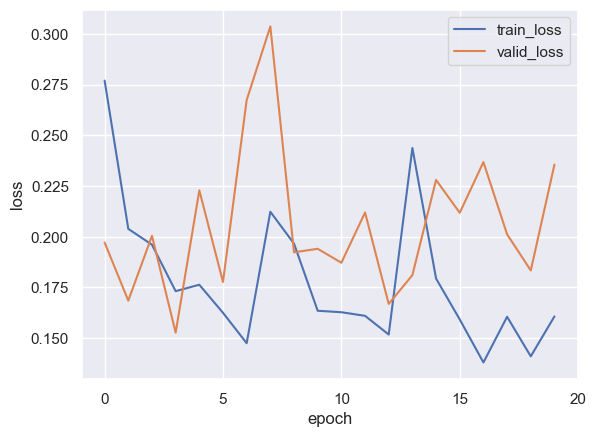

In [38]:
plot_loss(train_loss, valid_loss)

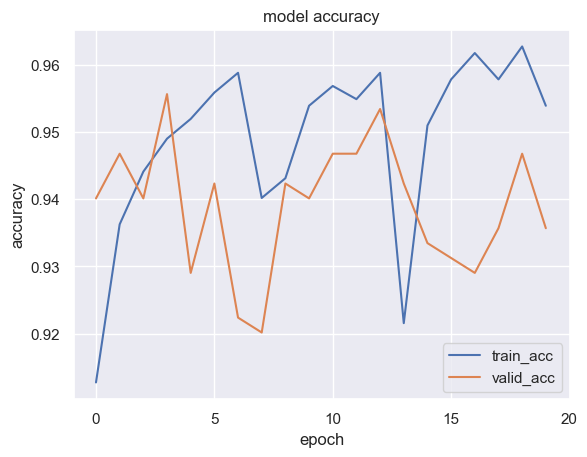

In [39]:
plot_metrics(train_acc, valid_acc)

In [40]:
print(f'accuracy: {max(valid_acc)}')

accuracy: 0.9556541019955654


## Atelectasisモデル

In [41]:
train_data = []
valid_data = []
for x, y in zip(X_train, Yatel_train):
    data = [x, y]
    train_data.append(data)
for x, y in zip(X_valid, Yatel_valid):
    data = [x, y]
    valid_data.append(data)
    
train_loader, valid_loader = build_data(train_data, valid_data, batch_size=batch_size)

In [42]:
config = BertConfig.from_json_file(model_path / 'bert_config.json')
bert = BertModel.from_pretrained(model_path / 'UTH_BERT.bin', config=config)
model = Net(bert, num_classes).to(device)

FREEZE=False
if FREEZE: 
    idx=1 #Any
    for name, param in model.named_parameters(): 
        param.requires_grad = False 
    for name, param in list(model.named_parameters())[idx:]: 
        param.requires_grad = True 
#     optimizer = optim.SGD([{'params':list(model.parameters())[idx:], 'lr':learning_rate, 'momentum':momentum}])
    optimizer = optim.Adam([{'params':list(model.parameters())[idx:], 'lr':learning_rate}]) 
    criterion = nn.CrossEntropyLoss()
else:  
#     optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [43]:
train_loss, valid_loss, train_acc, valid_acc = run(train_loader, valid_loader, model,
                                                             num_classes, epochs=epochs,
                                                             save_path=save_path/'atel')


Epoch 1/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1319, Train acc: 0.9647, Time: 94s
Valid loss: 0.1454, Valid acc: 0.9734

Epoch 2/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1060, Train acc: 0.9765, Time: 94s
Valid loss: 0.1075, Valid acc: 0.9690

Epoch 3/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.0965, Train acc: 0.9755, Time: 91s
Valid loss: 0.1525, Valid acc: 0.9667

Epoch 4/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.0865, Train acc: 0.9814, Time: 93s
Valid loss: 0.1004, Valid acc: 0.9734

Epoch 5/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.0638, Train acc: 0.9833, Time: 94s
Valid loss: 0.0929, Valid acc: 0.9778

Epoch 6/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.0656, Train acc: 0.9843, Time: 91s
Valid loss: 0.0885, Valid acc: 0.9756

Epoch 7/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.0976, Train acc: 0.9735, Time: 93s
Valid loss: 0.1497, Valid acc: 0.9601

Epoch 8/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1010, Train acc: 0.9775, Time: 94s
Valid loss: 0.1654, Valid acc: 0.9601

Epoch 9/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.0823, Train acc: 0.9775, Time: 91s
Valid loss: 0.1008, Valid acc: 0.9734

Epoch 10/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.0937, Train acc: 0.9716, Time: 93s
Valid loss: 0.1035, Valid acc: 0.9667

Epoch 11/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.0758, Train acc: 0.9794, Time: 94s
Valid loss: 0.1116, Valid acc: 0.9712

Epoch 12/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.0791, Train acc: 0.9794, Time: 91s
Valid loss: 0.1322, Valid acc: 0.9690

Epoch 13/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.0487, Train acc: 0.9902, Time: 92s
Valid loss: 0.1152, Valid acc: 0.9690

Epoch 14/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.0510, Train acc: 0.9902, Time: 94s
Valid loss: 0.1528, Valid acc: 0.9667

Epoch 15/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1072, Train acc: 0.9725, Time: 91s
Valid loss: 0.1392, Valid acc: 0.9601

Epoch 16/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.0780, Train acc: 0.9784, Time: 92s
Valid loss: 0.1032, Valid acc: 0.9712

Epoch 17/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.0727, Train acc: 0.9833, Time: 94s
Valid loss: 0.1005, Valid acc: 0.9756

Epoch 18/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.0612, Train acc: 0.9833, Time: 91s
Valid loss: 0.0979, Valid acc: 0.9800

Epoch 19/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.0656, Train acc: 0.9863, Time: 91s
Valid loss: 0.0965, Valid acc: 0.9800

Epoch 20/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.0643, Train acc: 0.9882, Time: 94s
Valid loss: 0.0919, Valid acc: 0.9778

Training complete
Best ACC: 0.9800 at epoch 17


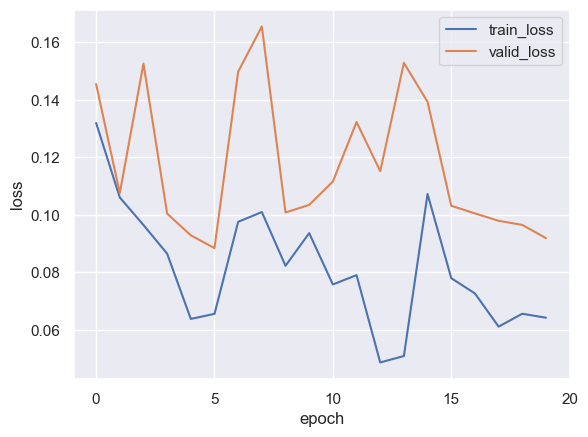

In [44]:
plot_loss(train_loss, valid_loss)

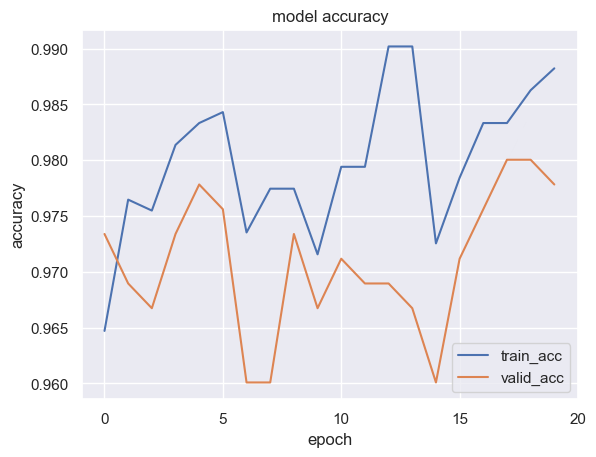

In [45]:
plot_metrics(train_acc, valid_acc)

In [46]:
print(f'accuracy: {max(valid_acc)}')

accuracy: 0.9800443458980045


## Satelliteモデル

In [47]:
train_data = []
valid_data = []
for x, y in zip(X_train, Ysate_train):
    data = [x, y]
    train_data.append(data)
for x, y in zip(X_valid, Ysate_valid):
    data = [x, y]
    valid_data.append(data)
    
train_loader, valid_loader = build_data(train_data, valid_data, batch_size=batch_size)

In [48]:
config = BertConfig.from_json_file(model_path / 'bert_config.json')
bert = BertModel.from_pretrained(model_path / 'UTH_BERT.bin', config=config)
model = Net(bert, num_classes).to(device)

FREEZE=False
if FREEZE: 
    idx=1 #Any
    for name, param in model.named_parameters(): 
        param.requires_grad = False 
    for name, param in list(model.named_parameters())[idx:]: 
        param.requires_grad = True 
#     optimizer = optim.SGD([{'params':list(model.parameters())[idx:], 'lr':learning_rate, 'momentum':momentum}])
    optimizer = optim.Adam([{'params':list(model.parameters())[idx:], 'lr':learning_rate}]) 
    criterion = nn.CrossEntropyLoss()
else:  
#     optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [49]:
train_loss, valid_loss, train_acc, valid_acc = run(train_loader, valid_loader, model,
                                                             num_classes, epochs=epochs,
                                                             save_path=save_path/'sate')


Epoch 1/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2592, Train acc: 0.9255, Time: 92s
Valid loss: 0.2326, Valid acc: 0.9290

Epoch 2/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2308, Train acc: 0.9275, Time: 91s
Valid loss: 0.2107, Valid acc: 0.9313

Epoch 3/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1882, Train acc: 0.9422, Time: 94s
Valid loss: 0.2532, Valid acc: 0.9224

Epoch 4/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1849, Train acc: 0.9422, Time: 93s
Valid loss: 0.2707, Valid acc: 0.9357

Epoch 5/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1545, Train acc: 0.9529, Time: 88s
Valid loss: 0.2526, Valid acc: 0.9379

Epoch 6/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1531, Train acc: 0.9569, Time: 65s
Valid loss: 0.2568, Valid acc: 0.9357

Epoch 7/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1472, Train acc: 0.9598, Time: 65s
Valid loss: 0.2079, Valid acc: 0.9379

Epoch 8/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1435, Train acc: 0.9627, Time: 65s
Valid loss: 0.2253, Valid acc: 0.9401

Epoch 9/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1390, Train acc: 0.9627, Time: 65s
Valid loss: 0.2490, Valid acc: 0.9335

Epoch 10/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1627, Train acc: 0.9549, Time: 65s
Valid loss: 0.2195, Valid acc: 0.9335

Epoch 11/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1548, Train acc: 0.9569, Time: 65s
Valid loss: 0.1901, Valid acc: 0.9401

Epoch 12/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1325, Train acc: 0.9657, Time: 65s
Valid loss: 0.2035, Valid acc: 0.9379

Epoch 13/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1488, Train acc: 0.9529, Time: 65s
Valid loss: 0.2425, Valid acc: 0.9335

Epoch 14/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1494, Train acc: 0.9549, Time: 65s
Valid loss: 0.2355, Valid acc: 0.9424

Epoch 15/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1680, Train acc: 0.9539, Time: 65s
Valid loss: 0.1965, Valid acc: 0.9379

Epoch 16/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1536, Train acc: 0.9608, Time: 65s
Valid loss: 0.2196, Valid acc: 0.9357

Epoch 17/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1711, Train acc: 0.9529, Time: 65s
Valid loss: 0.2189, Valid acc: 0.9335

Epoch 18/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1578, Train acc: 0.9520, Time: 65s
Valid loss: 0.2925, Valid acc: 0.9357

Epoch 19/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2239, Train acc: 0.9353, Time: 65s
Valid loss: 0.1992, Valid acc: 0.9379

Epoch 20/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1836, Train acc: 0.9500, Time: 65s
Valid loss: 0.2539, Valid acc: 0.9335

Training complete
Best ACC: 0.9424 at epoch 13


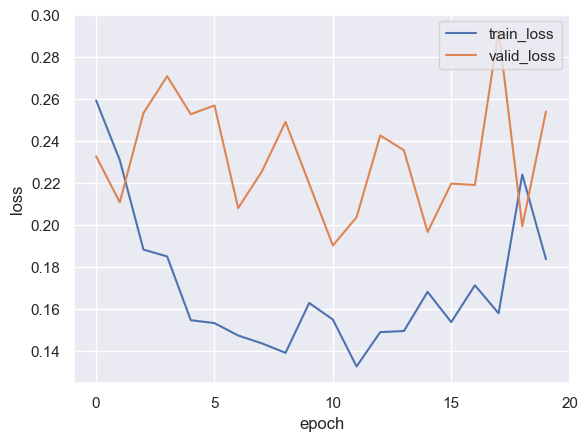

In [50]:
plot_loss(train_loss, valid_loss)

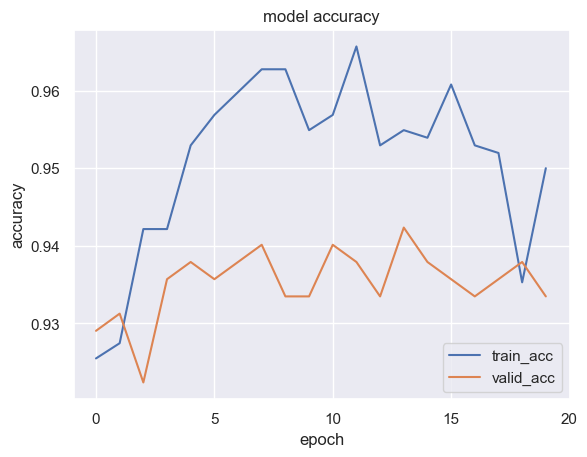

In [51]:
plot_metrics(train_acc, valid_acc)

In [52]:
print(f'accuracy: {max(valid_acc)}')

accuracy: 0.9423503325942351


## Lymphadenopathyモデル

In [53]:
train_data = []
valid_data = []
for x, y in zip(X_train, Ylymp_train):
    data = [x, y]
    train_data.append(data)
for x, y in zip(X_valid, Ylymp_valid):
    data = [x, y]
    valid_data.append(data)
    
train_loader, valid_loader = build_data(train_data, valid_data, batch_size=batch_size)

In [54]:
config = BertConfig.from_json_file(model_path / 'bert_config.json')
bert = BertModel.from_pretrained(model_path / 'UTH_BERT.bin', config=config)
model = Net(bert, num_classes).to(device)

FREEZE=False
if FREEZE: 
    idx=1 #Any
    for name, param in model.named_parameters(): 
        param.requires_grad = False 
    for name, param in list(model.named_parameters())[idx:]: 
        param.requires_grad = True 
#     optimizer = optim.SGD([{'params':list(model.parameters())[idx:], 'lr':learning_rate, 'momentum':momentum}])
    optimizer = optim.Adam([{'params':list(model.parameters())[idx:], 'lr':learning_rate}]) 
    criterion = nn.CrossEntropyLoss()
else:  
#     optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [55]:
train_loss, valid_loss, train_acc, valid_acc = run(train_loader, valid_loader, model,
                                                             num_classes, epochs=epochs,
                                                             save_path=save_path/'lymp')


Epoch 1/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.3152, Train acc: 0.8961, Time: 65s
Valid loss: 0.1772, Valid acc: 0.9512

Epoch 2/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2234, Train acc: 0.9353, Time: 65s
Valid loss: 0.1712, Valid acc: 0.9534

Epoch 3/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2161, Train acc: 0.9294, Time: 65s
Valid loss: 0.1614, Valid acc: 0.9534

Epoch 4/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2223, Train acc: 0.9333, Time: 65s
Valid loss: 0.1417, Valid acc: 0.9601

Epoch 5/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2017, Train acc: 0.9402, Time: 65s
Valid loss: 0.1579, Valid acc: 0.9557

Epoch 6/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2058, Train acc: 0.9373, Time: 65s
Valid loss: 0.1992, Valid acc: 0.9335

Epoch 7/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2325, Train acc: 0.9225, Time: 65s
Valid loss: 0.1641, Valid acc: 0.9534

Epoch 8/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1867, Train acc: 0.9480, Time: 65s
Valid loss: 0.1651, Valid acc: 0.9534

Epoch 9/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1753, Train acc: 0.9520, Time: 65s
Valid loss: 0.1638, Valid acc: 0.9534

Epoch 10/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1927, Train acc: 0.9412, Time: 65s
Valid loss: 0.1567, Valid acc: 0.9490

Epoch 11/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1711, Train acc: 0.9480, Time: 65s
Valid loss: 0.1646, Valid acc: 0.9512

Epoch 12/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1893, Train acc: 0.9392, Time: 65s
Valid loss: 0.1466, Valid acc: 0.9601

Epoch 13/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2053, Train acc: 0.9392, Time: 65s
Valid loss: 0.1683, Valid acc: 0.9512

Epoch 14/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1788, Train acc: 0.9490, Time: 65s
Valid loss: 0.1508, Valid acc: 0.9579

Epoch 15/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1869, Train acc: 0.9422, Time: 65s
Valid loss: 0.1519, Valid acc: 0.9579

Epoch 16/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1929, Train acc: 0.9412, Time: 65s
Valid loss: 0.1421, Valid acc: 0.9601

Epoch 17/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1862, Train acc: 0.9412, Time: 65s
Valid loss: 0.1586, Valid acc: 0.9534

Epoch 18/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1802, Train acc: 0.9441, Time: 65s
Valid loss: 0.2171, Valid acc: 0.9424

Epoch 19/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2080, Train acc: 0.9333, Time: 65s
Valid loss: 0.1986, Valid acc: 0.9424

Epoch 20/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1937, Train acc: 0.9392, Time: 65s
Valid loss: 0.1563, Valid acc: 0.9601

Training complete
Best ACC: 0.9601 at epoch 3


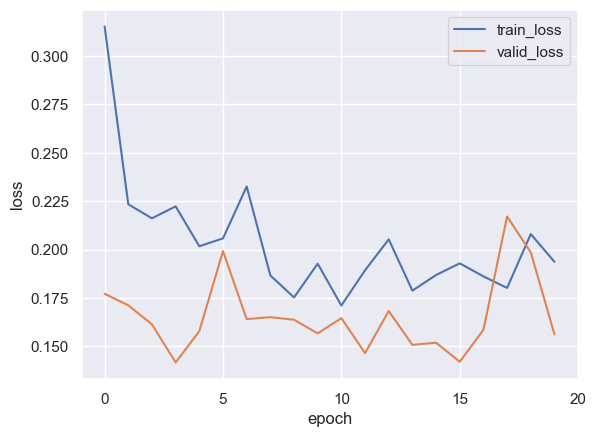

In [56]:
plot_loss(train_loss, valid_loss)

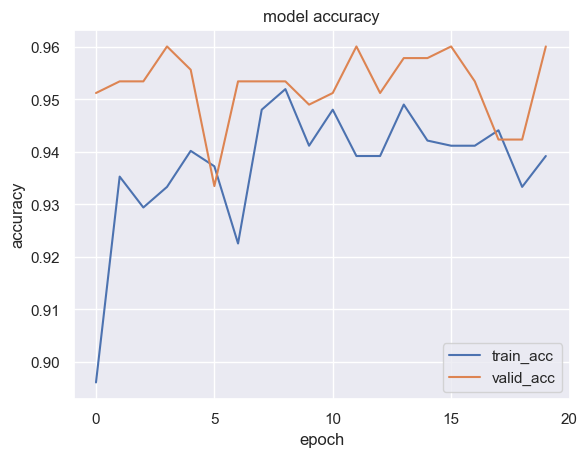

In [57]:
plot_metrics(train_acc, valid_acc)

In [58]:
print(f'accuracy: {max(valid_acc)}')

accuracy: 0.9600886917960089


## Pleuralモデル

In [59]:
train_data = []
valid_data = []
for x, y in zip(X_train, Ypleu_train):
    data = [x, y]
    train_data.append(data)
for x, y in zip(X_valid, Ypleu_valid):
    data = [x, y]
    valid_data.append(data)
    
train_loader, valid_loader = build_data(train_data, valid_data, batch_size=batch_size)

In [60]:
config = BertConfig.from_json_file(model_path / 'bert_config.json')
bert = BertModel.from_pretrained(model_path / 'UTH_BERT.bin', config=config)
model = Net(bert, num_classes).to(device)

FREEZE=False
if FREEZE: 
    idx=1 #Any
    for name, param in model.named_parameters(): 
        param.requires_grad = False 
    for name, param in list(model.named_parameters())[idx:]: 
        param.requires_grad = True 
#     optimizer = optim.SGD([{'params':list(model.parameters())[idx:], 'lr':learning_rate, 'momentum':momentum}])
    optimizer = optim.Adam([{'params':list(model.parameters())[idx:], 'lr':learning_rate}]) 
    criterion = nn.CrossEntropyLoss()
else:  
#     optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [61]:
train_loss, valid_loss, train_acc, valid_acc = run(train_loader, valid_loader, model,
                                                             num_classes, epochs=epochs,
                                                             save_path=save_path/'pleu')


Epoch 1/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1326, Train acc: 0.9745, Time: 65s
Valid loss: 0.3394, Valid acc: 0.9069

Epoch 2/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1137, Train acc: 0.9745, Time: 65s
Valid loss: 0.4139, Valid acc: 0.9069

Epoch 3/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1194, Train acc: 0.9745, Time: 65s
Valid loss: 0.2931, Valid acc: 0.9069

Epoch 4/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1035, Train acc: 0.9775, Time: 65s
Valid loss: 0.3223, Valid acc: 0.9069

Epoch 5/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1133, Train acc: 0.9755, Time: 65s
Valid loss: 0.3119, Valid acc: 0.9113

Epoch 6/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.0955, Train acc: 0.9725, Time: 65s
Valid loss: 0.3587, Valid acc: 0.9157

Epoch 7/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.0878, Train acc: 0.9804, Time: 65s
Valid loss: 0.3778, Valid acc: 0.9202

Epoch 8/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1056, Train acc: 0.9765, Time: 65s
Valid loss: 0.3319, Valid acc: 0.9069

Epoch 9/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.0879, Train acc: 0.9794, Time: 65s
Valid loss: 0.3404, Valid acc: 0.9202

Epoch 10/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.0941, Train acc: 0.9784, Time: 65s
Valid loss: 0.3587, Valid acc: 0.9069

Epoch 11/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1070, Train acc: 0.9745, Time: 65s
Valid loss: 0.3088, Valid acc: 0.9069

Epoch 12/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1038, Train acc: 0.9735, Time: 65s
Valid loss: 0.4752, Valid acc: 0.9091

Epoch 13/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1077, Train acc: 0.9735, Time: 65s
Valid loss: 0.3521, Valid acc: 0.9157

Epoch 14/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.0954, Train acc: 0.9745, Time: 65s
Valid loss: 0.3176, Valid acc: 0.9202

Epoch 15/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.0896, Train acc: 0.9784, Time: 65s
Valid loss: 0.3322, Valid acc: 0.9246

Epoch 16/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.0888, Train acc: 0.9784, Time: 65s
Valid loss: 0.3882, Valid acc: 0.9224

Epoch 17/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.0854, Train acc: 0.9755, Time: 65s
Valid loss: 0.4763, Valid acc: 0.9069

Epoch 18/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.0877, Train acc: 0.9794, Time: 65s
Valid loss: 0.3447, Valid acc: 0.9268

Epoch 19/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.0804, Train acc: 0.9814, Time: 65s
Valid loss: 0.4258, Valid acc: 0.9202

Epoch 20/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.0820, Train acc: 0.9814, Time: 65s
Valid loss: 0.3977, Valid acc: 0.9157

Training complete
Best ACC: 0.9268 at epoch 17


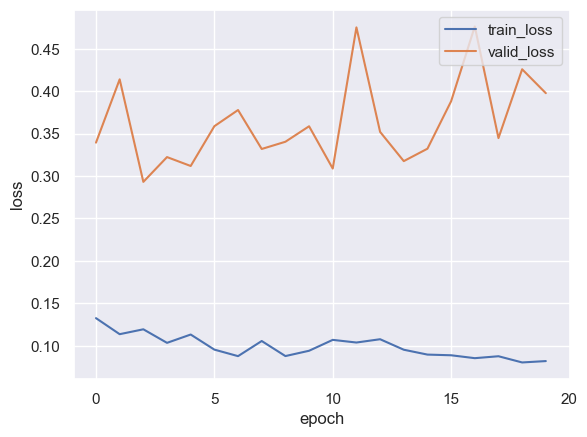

In [62]:
plot_loss(train_loss, valid_loss)

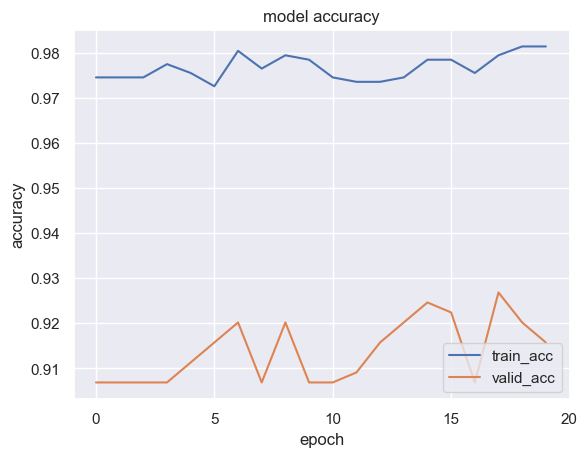

In [63]:
plot_metrics(train_acc, valid_acc)

In [64]:
print(f'accuracy: {max(valid_acc)}')

accuracy: 0.926829268292683


## Distantモデル

In [65]:
train_data = []
valid_data = []
for x, y in zip(X_train, Ydist_train):
    data = [x, y]
    train_data.append(data)
for x, y in zip(X_valid, Ydist_valid):
    data = [x, y]
    valid_data.append(data)
    
train_loader, valid_loader = build_data(train_data, valid_data, batch_size=batch_size)

In [66]:
config = BertConfig.from_json_file(model_path / 'bert_config.json')
bert = BertModel.from_pretrained(model_path / 'UTH_BERT.bin', config=config)
model = Net(bert, num_classes).to(device)

FREEZE=False
if FREEZE: 
    idx=1 #Any
    for name, param in model.named_parameters(): 
        param.requires_grad = False 
    for name, param in list(model.named_parameters())[idx:]: 
        param.requires_grad = True 
#     optimizer = optim.SGD([{'params':list(model.parameters())[idx:], 'lr':learning_rate, 'momentum':momentum}])
    optimizer = optim.Adam([{'params':list(model.parameters())[idx:], 'lr':learning_rate}]) 
    criterion = nn.CrossEntropyLoss()
else:  
#     optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [67]:
train_loss, valid_loss, train_acc, valid_acc = run(train_loader, valid_loader, model,
                                                             num_classes, epochs=epochs,
                                                             save_path=save_path/'dist')


Epoch 1/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.3095, Train acc: 0.9157, Time: 65s
Valid loss: 0.3565, Valid acc: 0.8958

Epoch 2/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2964, Train acc: 0.9167, Time: 65s
Valid loss: 0.3353, Valid acc: 0.8958

Epoch 3/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2882, Train acc: 0.9167, Time: 65s
Valid loss: 0.3324, Valid acc: 0.8958

Epoch 4/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2799, Train acc: 0.9186, Time: 65s
Valid loss: 0.2929, Valid acc: 0.9069

Epoch 5/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2141, Train acc: 0.9392, Time: 65s
Valid loss: 0.2425, Valid acc: 0.9157

Epoch 6/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1996, Train acc: 0.9431, Time: 65s
Valid loss: 0.2692, Valid acc: 0.9113

Epoch 7/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1809, Train acc: 0.9480, Time: 65s
Valid loss: 0.4143, Valid acc: 0.9002

Epoch 8/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1867, Train acc: 0.9510, Time: 65s
Valid loss: 0.2439, Valid acc: 0.9290

Epoch 9/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1692, Train acc: 0.9480, Time: 65s
Valid loss: 0.2644, Valid acc: 0.9224

Epoch 10/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1567, Train acc: 0.9529, Time: 65s
Valid loss: 0.2384, Valid acc: 0.9246

Epoch 11/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1487, Train acc: 0.9559, Time: 65s
Valid loss: 0.2670, Valid acc: 0.9180

Epoch 12/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1901, Train acc: 0.9441, Time: 65s
Valid loss: 0.3458, Valid acc: 0.9224

Epoch 13/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1846, Train acc: 0.9500, Time: 65s
Valid loss: 0.2974, Valid acc: 0.8958

Epoch 14/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.2083, Train acc: 0.9382, Time: 65s
Valid loss: 0.3215, Valid acc: 0.9113

Epoch 15/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1754, Train acc: 0.9510, Time: 65s
Valid loss: 0.3381, Valid acc: 0.9113

Epoch 16/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1511, Train acc: 0.9578, Time: 65s
Valid loss: 0.2935, Valid acc: 0.9180

Epoch 17/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1874, Train acc: 0.9461, Time: 65s
Valid loss: 0.2479, Valid acc: 0.9224

Epoch 18/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1658, Train acc: 0.9529, Time: 65s
Valid loss: 0.2844, Valid acc: 0.9091

Epoch 19/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1803, Train acc: 0.9490, Time: 65s
Valid loss: 0.3214, Valid acc: 0.9091

Epoch 20/20
----------


  0%|          | 0/510 [00:00<?, ?it/s]

Train loss: 0.1560, Train acc: 0.9569, Time: 65s
Valid loss: 0.3000, Valid acc: 0.9091

Training complete
Best ACC: 0.9290 at epoch 7


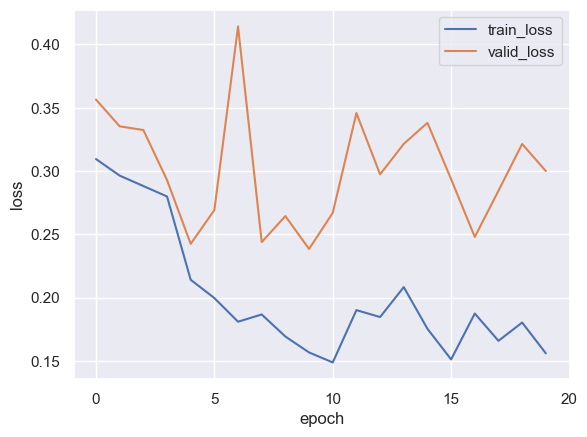

In [68]:
plot_loss(train_loss, valid_loss)

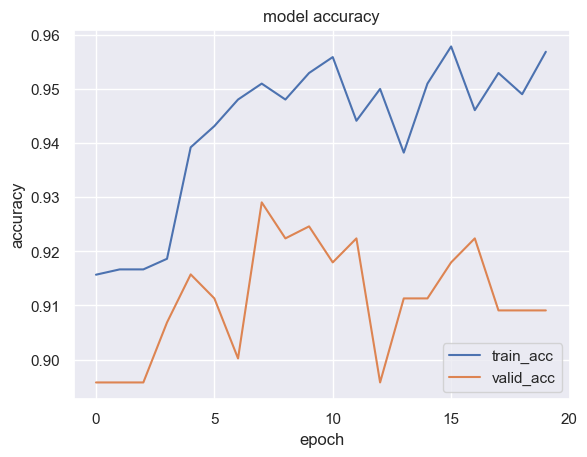

In [69]:
plot_metrics(train_acc, valid_acc)

In [70]:
print(f'accuracy: {max(valid_acc)}')

accuracy: 0.9290465631929047
